In [2]:
import numpy as np
from glob import glob 
import pickle
import h5py
import inspect
import astropy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn.apionly as sns
import pandas as pd
import healpy as hp
from icecube import astro
%matplotlib inline
%load_ext memory_profiler
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from numpy.lib.recfunctions import append_fields

import matplotlib as mpl
plt.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')
palette = sns.color_palette('colorblind')

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [3]:
neutrinos = np.load('/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/IC86_2012.numu_with_delta_psi.npy')
#neutrinos = np.load('/data/user/apizzuto/Nova/RandomForests/IC86_2012-2018MC_with_dpsi_with_Nstring.npy')
neutrinos_df = pd.DataFrame.from_dict(neutrinos)

# IF JUST NUMU:
neutrinos_df = neutrinos_df[np.abs(neutrinos_df['ptype']) == 14]
# IF JUST CC
#neutrinos_df = neutrinos_df[neutrinos_df['iscc'] == True]
weights = neutrinos_df['ow']

neutrinos_df['int_type'] = np.where(neutrinos_df['iscc'] == False, 'NC', 'CC')
#for flav, pid in [('numu', 14.), ('nue', 12.), ('nutau', 16.)]:
#    neutrinos_df.loc[(np.abs(neutrinos_df.ptype) == pid) &  
#            (neutrinos_df.int_type == 'CC'), 'int_type'] = '{} CC'.format(flav)

#neutrinos_df['deltaSinDec'] = np.sin(neutrinos_df['trueDec']) - np.sin(neutrinos_df['dec'])
#delra = np.abs(neutrinos_df['trueRa'] - neutrinos_df['ra'])
#neutrinos_df['deltaRa'] = np.where(delra < np.pi, delra, 2*np.pi - delra)
neutrinos_df = neutrinos_df.drop(['run', 'event', 'subevent', 'angErr', 'trueE', 'azi', 'monopod_azi',
                                  'trueRa', 'trueDec', 'time', 'ptype', 'iscc',
                                  #'trueDeltaLLH', 
                                  'ra', 'dec', 'monopod_ra', 
                                  'monopod_dec', 'ow', 
                                 'conv', 'prompt', 'astro'], axis = 'columns')

old_names = neutrinos_df.columns
new_names = [on.replace('_', ' ') for on in old_names]
neutrinos_df.columns = new_names
#print np.count_nonzero(neutrinos_df['logE'] == -np.inf)
neutrinos_df = neutrinos_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
neutrinos_df.head()

nstring  nchannel       zen      logE  cascade energy  monopod zen  \
0        3        11  1.420211  1.210091        9.561498     1.416658   
1        4        39  1.645680  1.831513       11.234188     1.652230   
2        3        17  2.407896  1.306948       10.284401     1.943617   
3        3        16  2.472532  1.210983        2.934846     2.286721   
4        4        33  2.007776  1.492481        0.000000     2.549248   

   pidDeltaLLH  pidPeglegLLH  pidMonopodLLH  pidLength  monopod pegleg dpsi  \
0    -2.776274    152.464142     155.240417       30.0             0.049951   
1   -78.239273    408.432404     486.671661      255.0             0.781548   
2    -3.200060    216.126541     219.326614       45.0             0.651062   
3    -9.787460    190.214737     200.002197       60.0             0.663713   
4   -25.163954    318.100342     343.264313      140.0             0.918263   

   true dpsi int type  
0   0.480986       CC  
1   0.057427       CC  
2   0.334459       CC  
3   1.085186       CC  
4   0.043507       CC

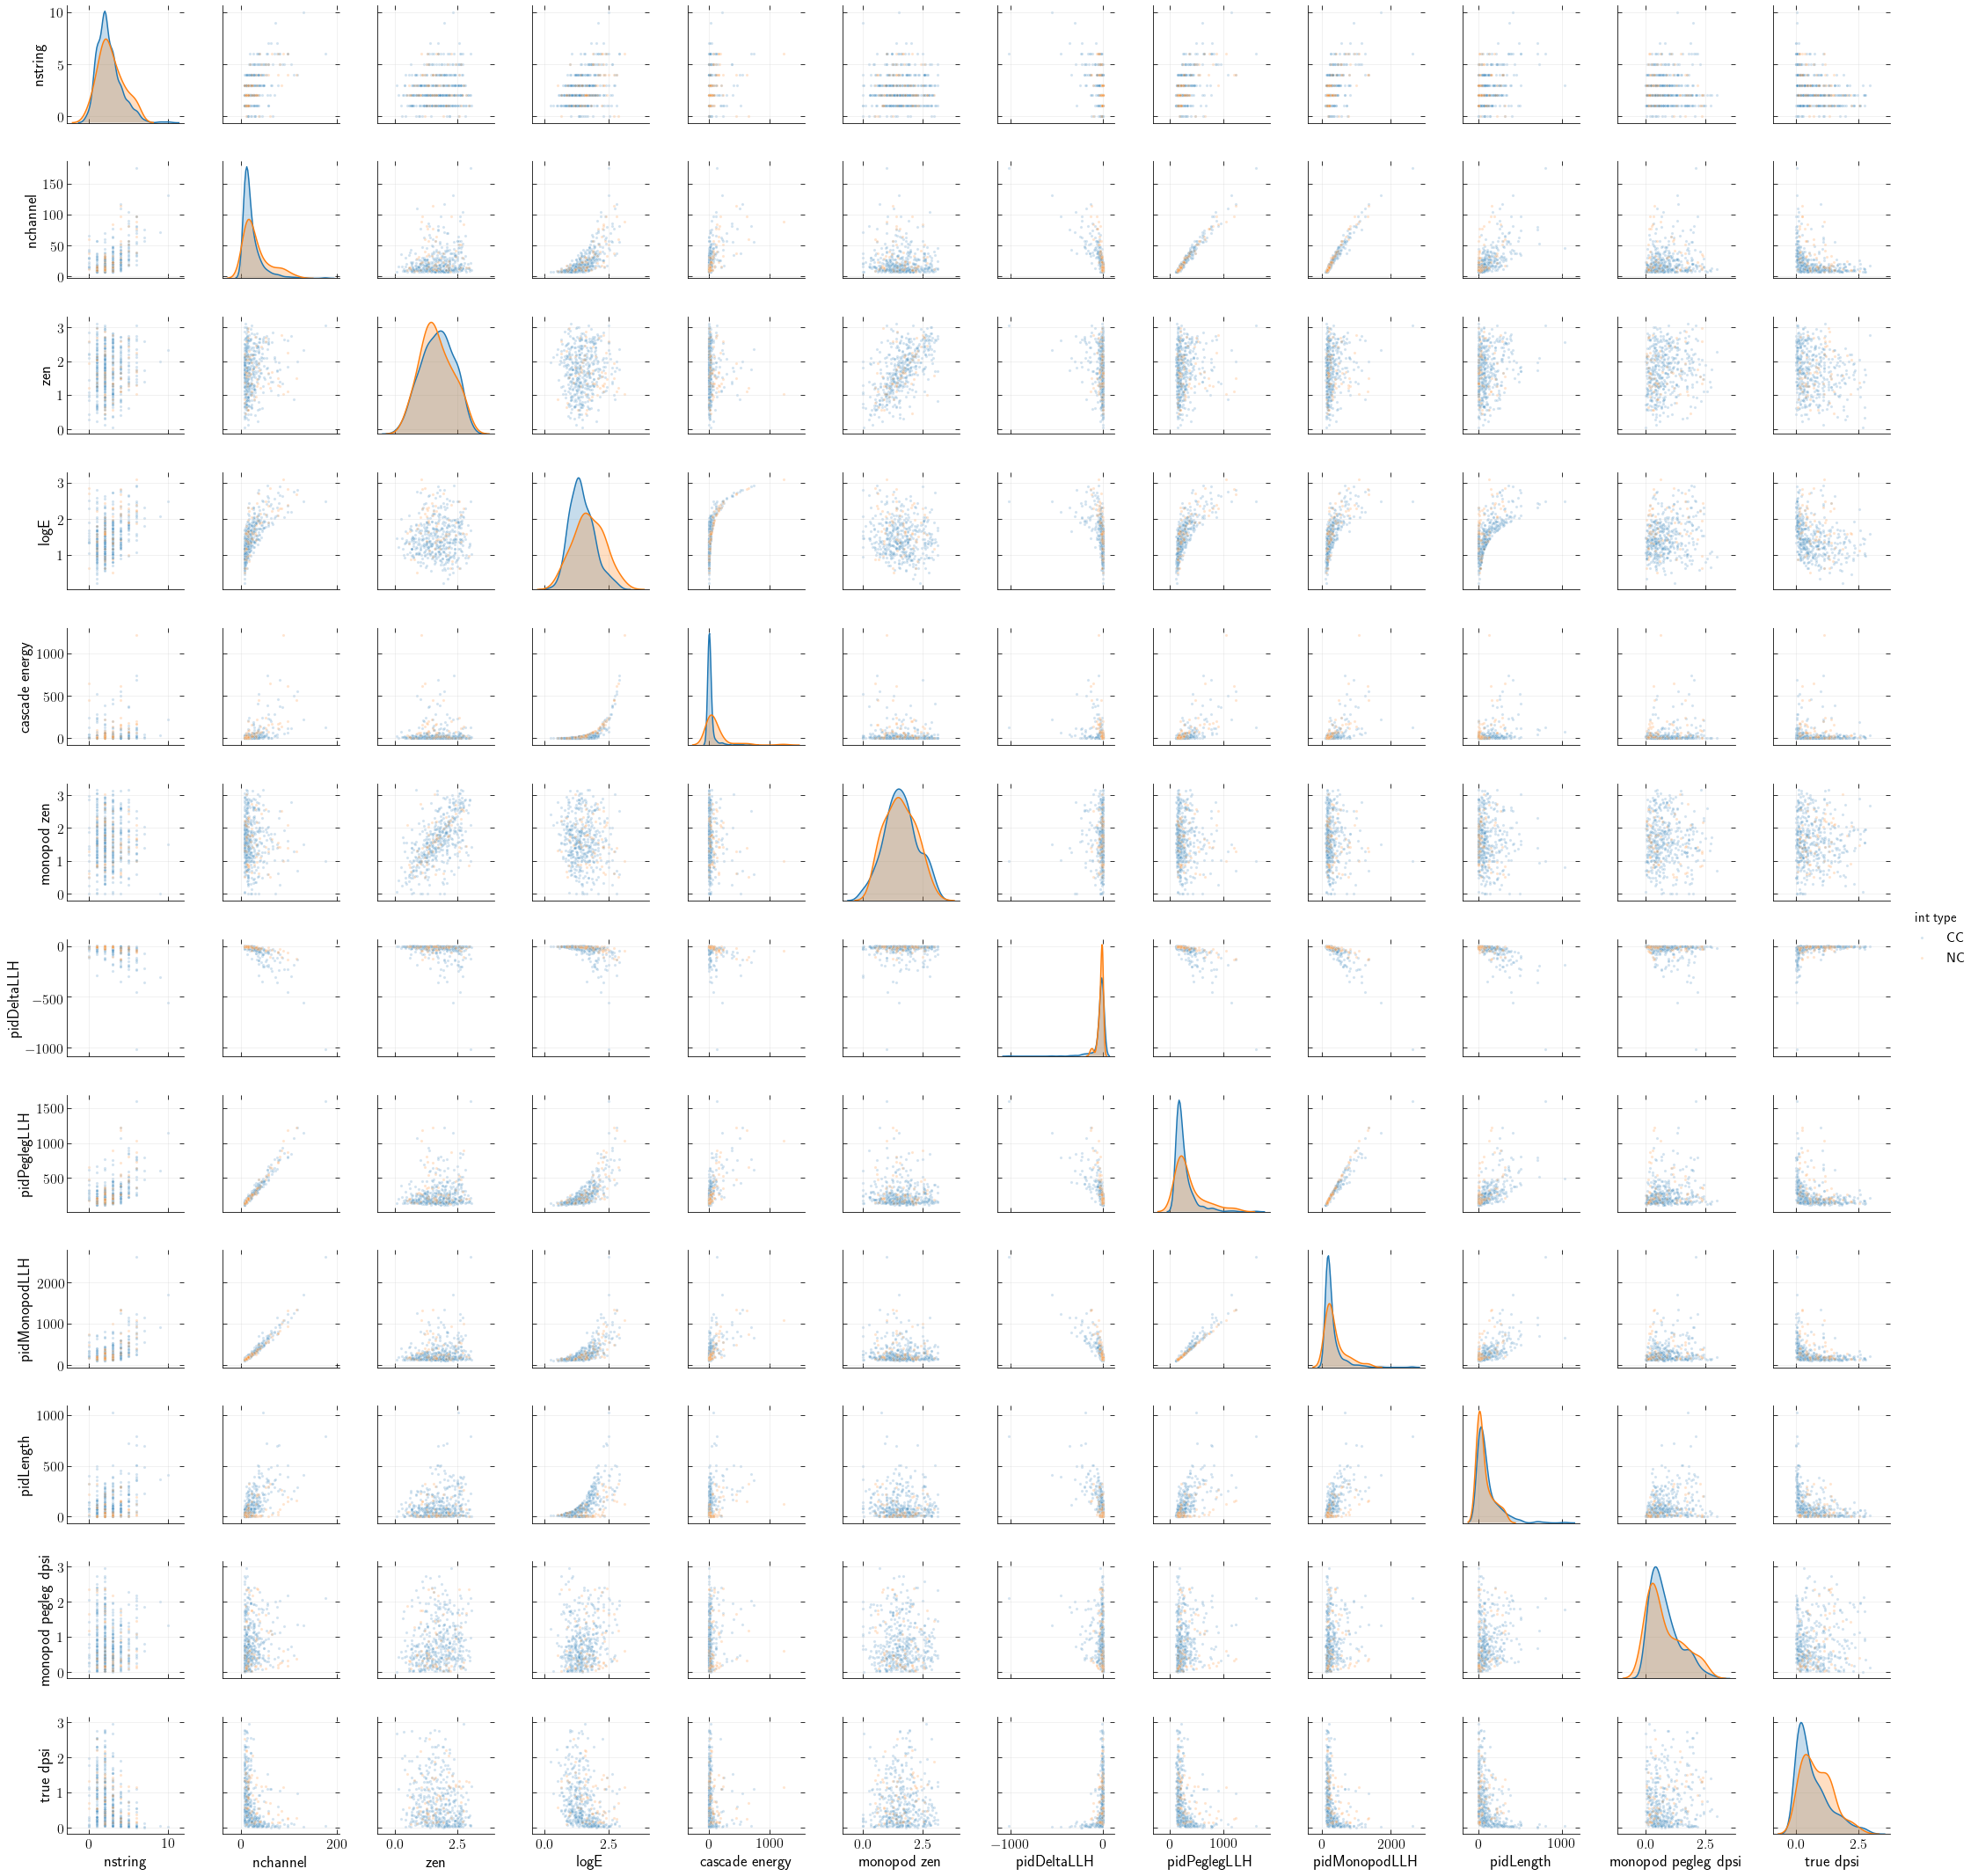

In [4]:
sns.pairplot(neutrinos_df.sample(n=500), plot_kws={"s": 10, "alpha": 0.2, "edgecolors": None}, hue = 'int type')
plt.show()

In [5]:
scaled_nus = neutrinos_df.copy()
#scaled_nus['true dpsi'] = np.log10(neutrinos_df['true dpsi']*180. / np.pi)
scaled_nus['monopod zen'] = np.cos(neutrinos_df['monopod zen'])
scaled_nus['zen'] = np.cos(neutrinos_df['zen'])
scaled_nus['pidMonopodLLH'] = np.log10(neutrinos_df['pidMonopodLLH'])
#scaled_nus['monopod pegleg dpsi'] = np.power(neutrinos_df['monopod pegleg dpsi'], 0.5)
#scaled_nus['pidLength'] = np.where(neutrinos_df['pidLength'] > 0., np.log10(neutrinos_df['pidLength']), 0.)

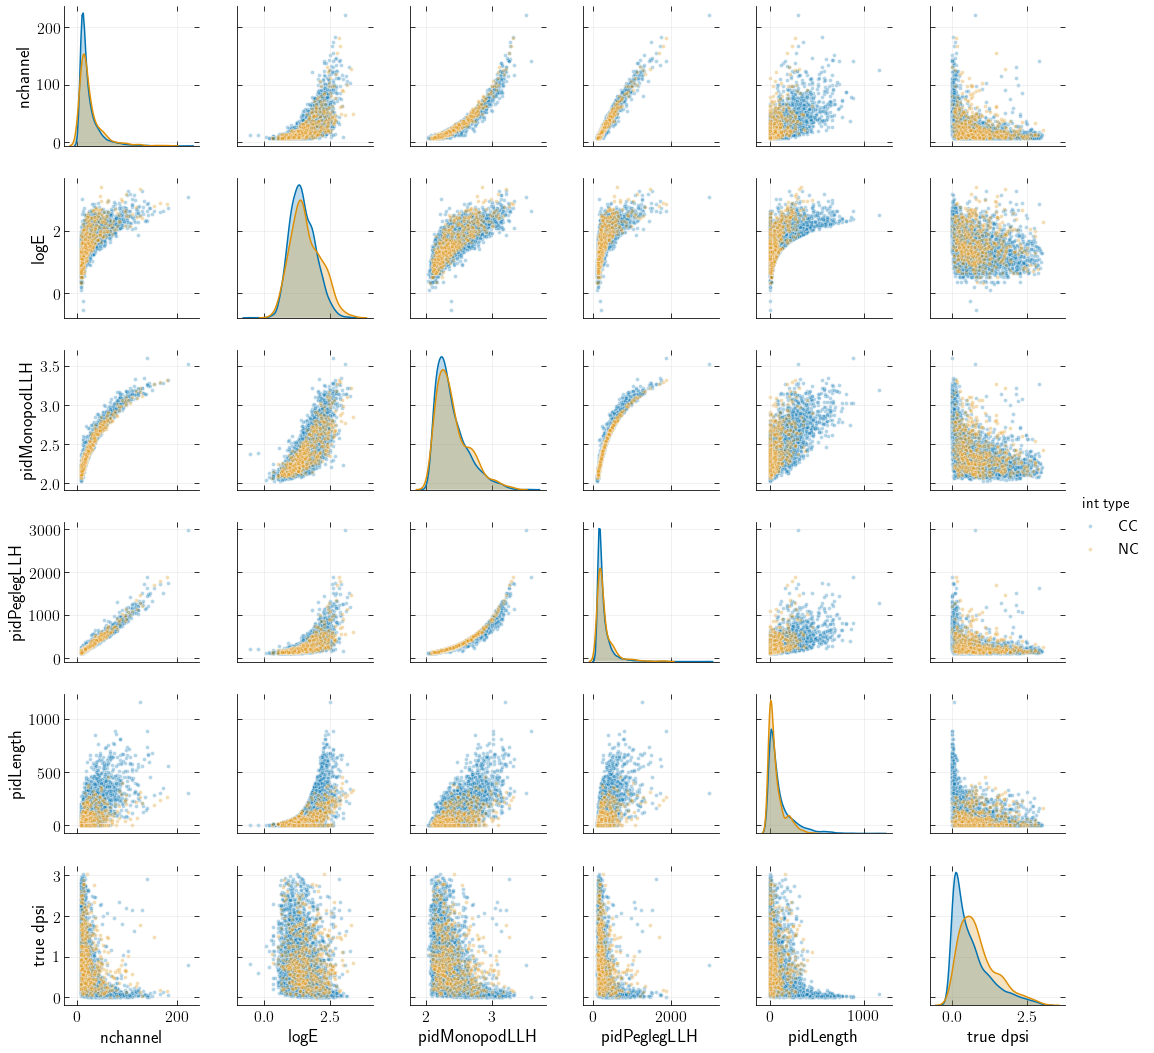

In [6]:
sns.pairplot(scaled_nus.sample(n=5000), vars=['nchannel', 'logE', "pidMonopodLLH", 'pidPeglegLLH', 'pidLength', "true dpsi"], 
             plot_kws={"s": 15, "alpha": 0.3, "edgecolors": None}, hue='int type', palette='colorblind')
plt.show()

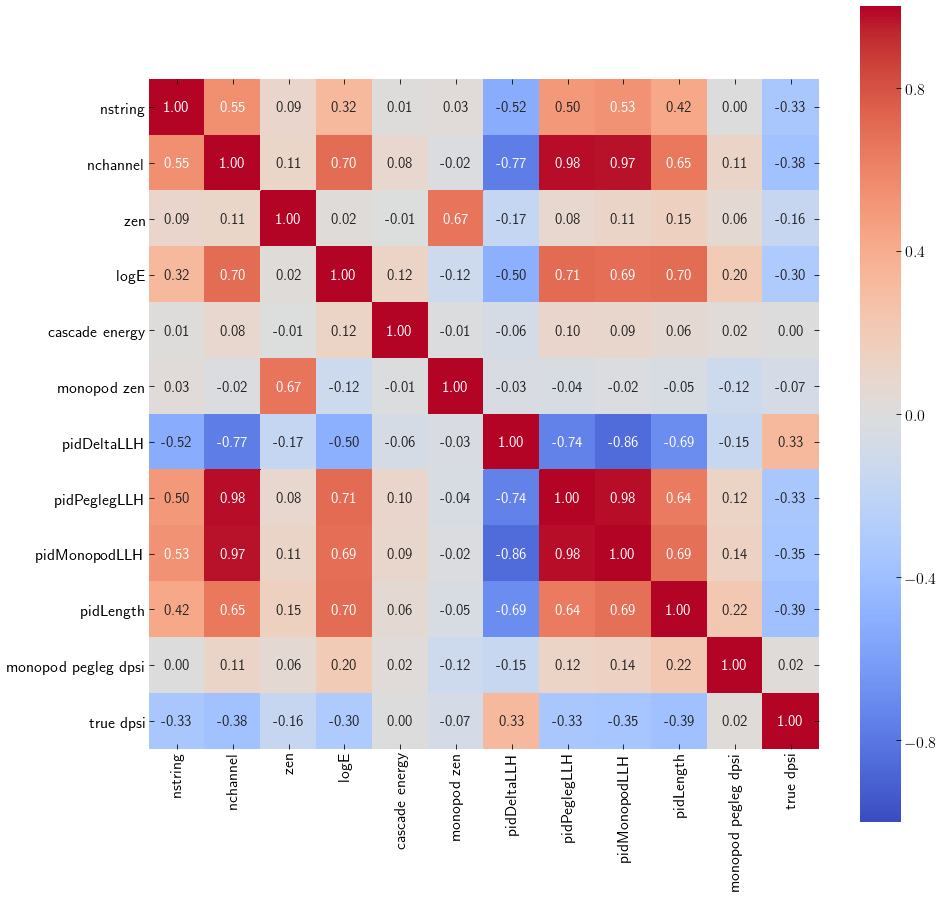

In [7]:
plt.figure(figsize = (15,15))
neutrinos_df = neutrinos_df.drop(['int type'], axis = 'columns')

cm = np.corrcoef(neutrinos_df.values.T)
#sns.set(font_scale=2.5)
hm = sns.heatmap(cm,
           cbar=True,
           annot=True,
           square=True,
           fmt='.2f',
           annot_kws={'size': 15},
           yticklabels=neutrinos_df.columns,
           xticklabels=neutrinos_df.columns,
           vmin = -1, cmap = 'coolwarm')
plt.show()

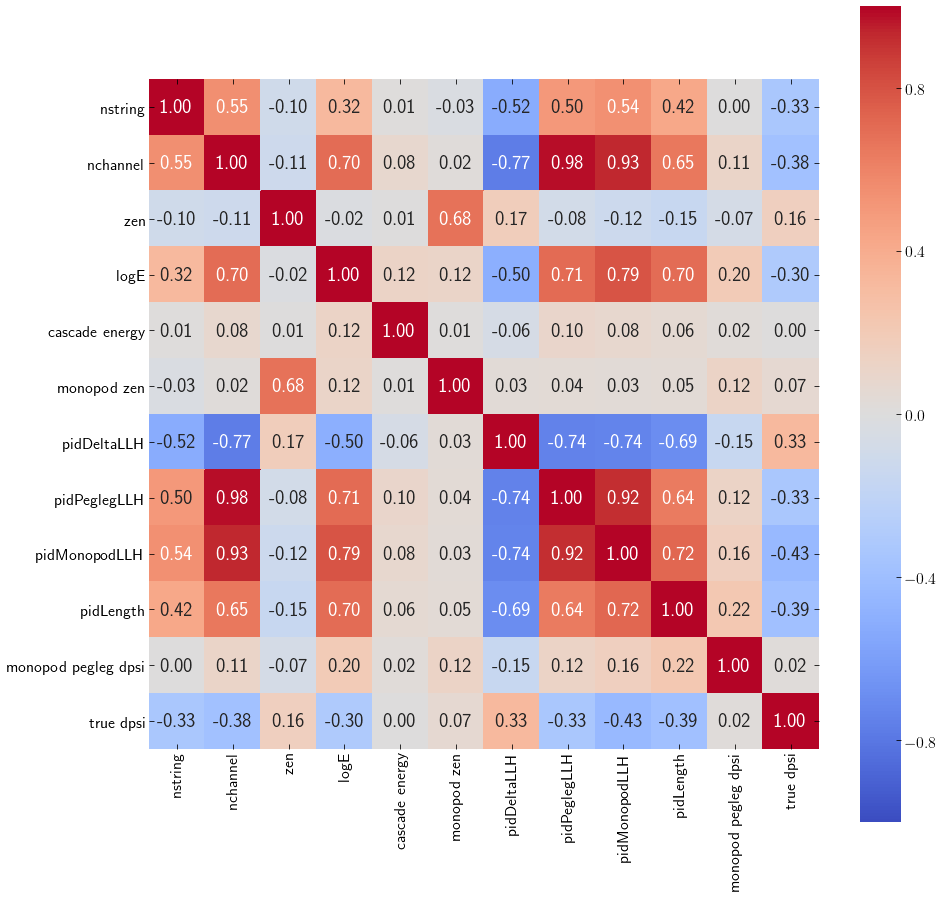

In [8]:
plt.figure(figsize = (15,15))
#cm = np.corrcoef(neutrinos_df.values.T)
scaled_nus = scaled_nus.drop(['int type'], axis = 'columns')

cm = np.corrcoef(scaled_nus.values.T)
#sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
           cbar=True,
           annot=True,
           square=True,
           fmt='.2f',
           annot_kws={'size': 20},
           yticklabels=neutrinos_df.columns,
           xticklabels=neutrinos_df.columns,
           vmin = -1, cmap = 'coolwarm')
plt.show()

In [9]:
neutrinos_df = scaled_nus.copy()

In [10]:
feature_cols = list(neutrinos_df.keys())
feature_cols.remove('true dpsi')

X,y = neutrinos_df[feature_cols].values, neutrinos_df['true dpsi'].values

test_vals = []
test_vals_std = []
train_vals = []
#test_fracs = np.linspace(0.01, 0.99, 3)
test_fracs = np.linspace(0.01, 0.5, 3)

for test_frac in test_fracs:
    if True: #test_frac % 0.11 == 0:
        print("\nSize: {}".format(len(neutrinos_df['true dpsi'])*(1.-test_frac)))

    X_train, X_test, y_train, y_test =  train_test_split(X, y, 
                                                         test_size=test_frac, 
                                                         random_state=1) 
    #Unstandardized
    forest = RandomForestRegressor(n_estimators=50, 
                                   max_depth = 25,
                                   max_features = 4,
                                   min_samples_split = 100,
                                   criterion='mse', #'entropy', 'genie'
                                   random_state=1, 
                                   n_jobs=10)

    forest.fit(X_train, y_train)
    y_train_pred = forest.predict(X_train)
    y_test_pred = forest.predict(X_test)

    if True: #test_frac % 0.11 == 0:
        print('MSE train: %.3f, test: %.3f' % (
                mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_test, y_test_pred)))
        print('R^2 train: %.3f, test: %.3f' % (
                r2_score(y_train, y_train_pred),
                r2_score(y_test, y_test_pred)))
    test_vals.append(mean_squared_error(y_test, y_test_pred))
    train_vals.append(mean_squared_error(y_train, y_train_pred))

    #standardized
    #stdsc = StandardScaler()
    #X_train_std = stdsc.fit(X_train).transform(X_train)
    #X_test_std = stdsc.transform(X_test)
    
    #forest.fit(X_train_std, y_train)
    #y_train_pred = forest.predict(X_train_std)
    #y_test_pred = forest.predict(X_test_std)

    #if True: #test_frac % 0.11 == 0:
    #    print("Standardized version:")
    #    print('MSE train: %.3f, test: %.3f' % (
    #            mean_squared_error(y_train, y_train_pred),
    #            mean_squared_error(y_test, y_test_pred)))
    #    print('R^2 train: %.3f, test: %.3f' % (
    #            r2_score(y_train, y_train_pred),
    #            r2_score(y_test, y_test_pred)))
    #test_vals_std.append(mean_squared_error(y_test, y_test_pred))


#outfile = '/data/user/apizzuto/Nova/RandomForests/FakeForestForEarlySensitivities.sav'
#pickle.dump(fake_forest, open(outfile, 'wb'))


Size: 302592.51
MSE train: 0.212, test: 0.240
R^2 train: 0.462, test: 0.360

Size: 227708.505
MSE train: 0.213, test: 0.253
R^2 train: 0.461, test: 0.353

Size: 152824.5
MSE train: 0.213, test: 0.256
R^2 train: 0.461, test: 0.349


Feature ranking:
1. feature pidDeltaLLH 0.287413991642
2. feature nchannel 0.155242203093
3. feature pidMonopodLLH 0.0976535410977
4. feature pidLength 0.0924476590948
5. feature pidPeglegLLH 0.072058140711
6. feature monopod pegleg dpsi 0.0659864450337
7. feature cascade energy 0.0636662196709
8. feature zen 0.0517002906551
9. feature logE 0.0505868111761
10. feature monopod zen 0.0327517288446
11. feature nstring 0.0304929689805


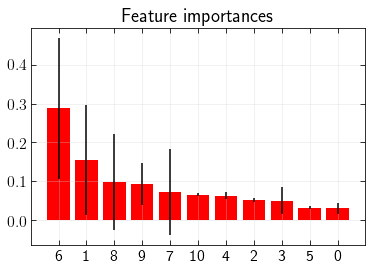

In [11]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}. feature {} {}".format(f + 1, neutrinos_df.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Text(0,0.5,'Mean Squared Error')

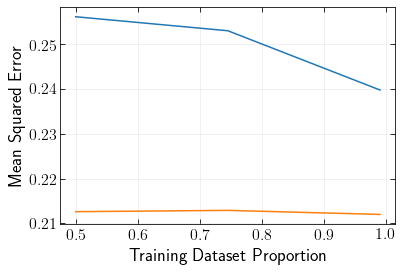

In [12]:
train_fracs = 1.- test_fracs

plt.plot(train_fracs, test_vals)
#plt.plot(train_fracs, test_vals_std)
plt.plot(train_fracs, train_vals)
plt.xlabel('Training Dataset Proportion')
plt.ylabel('Mean Squared Error')


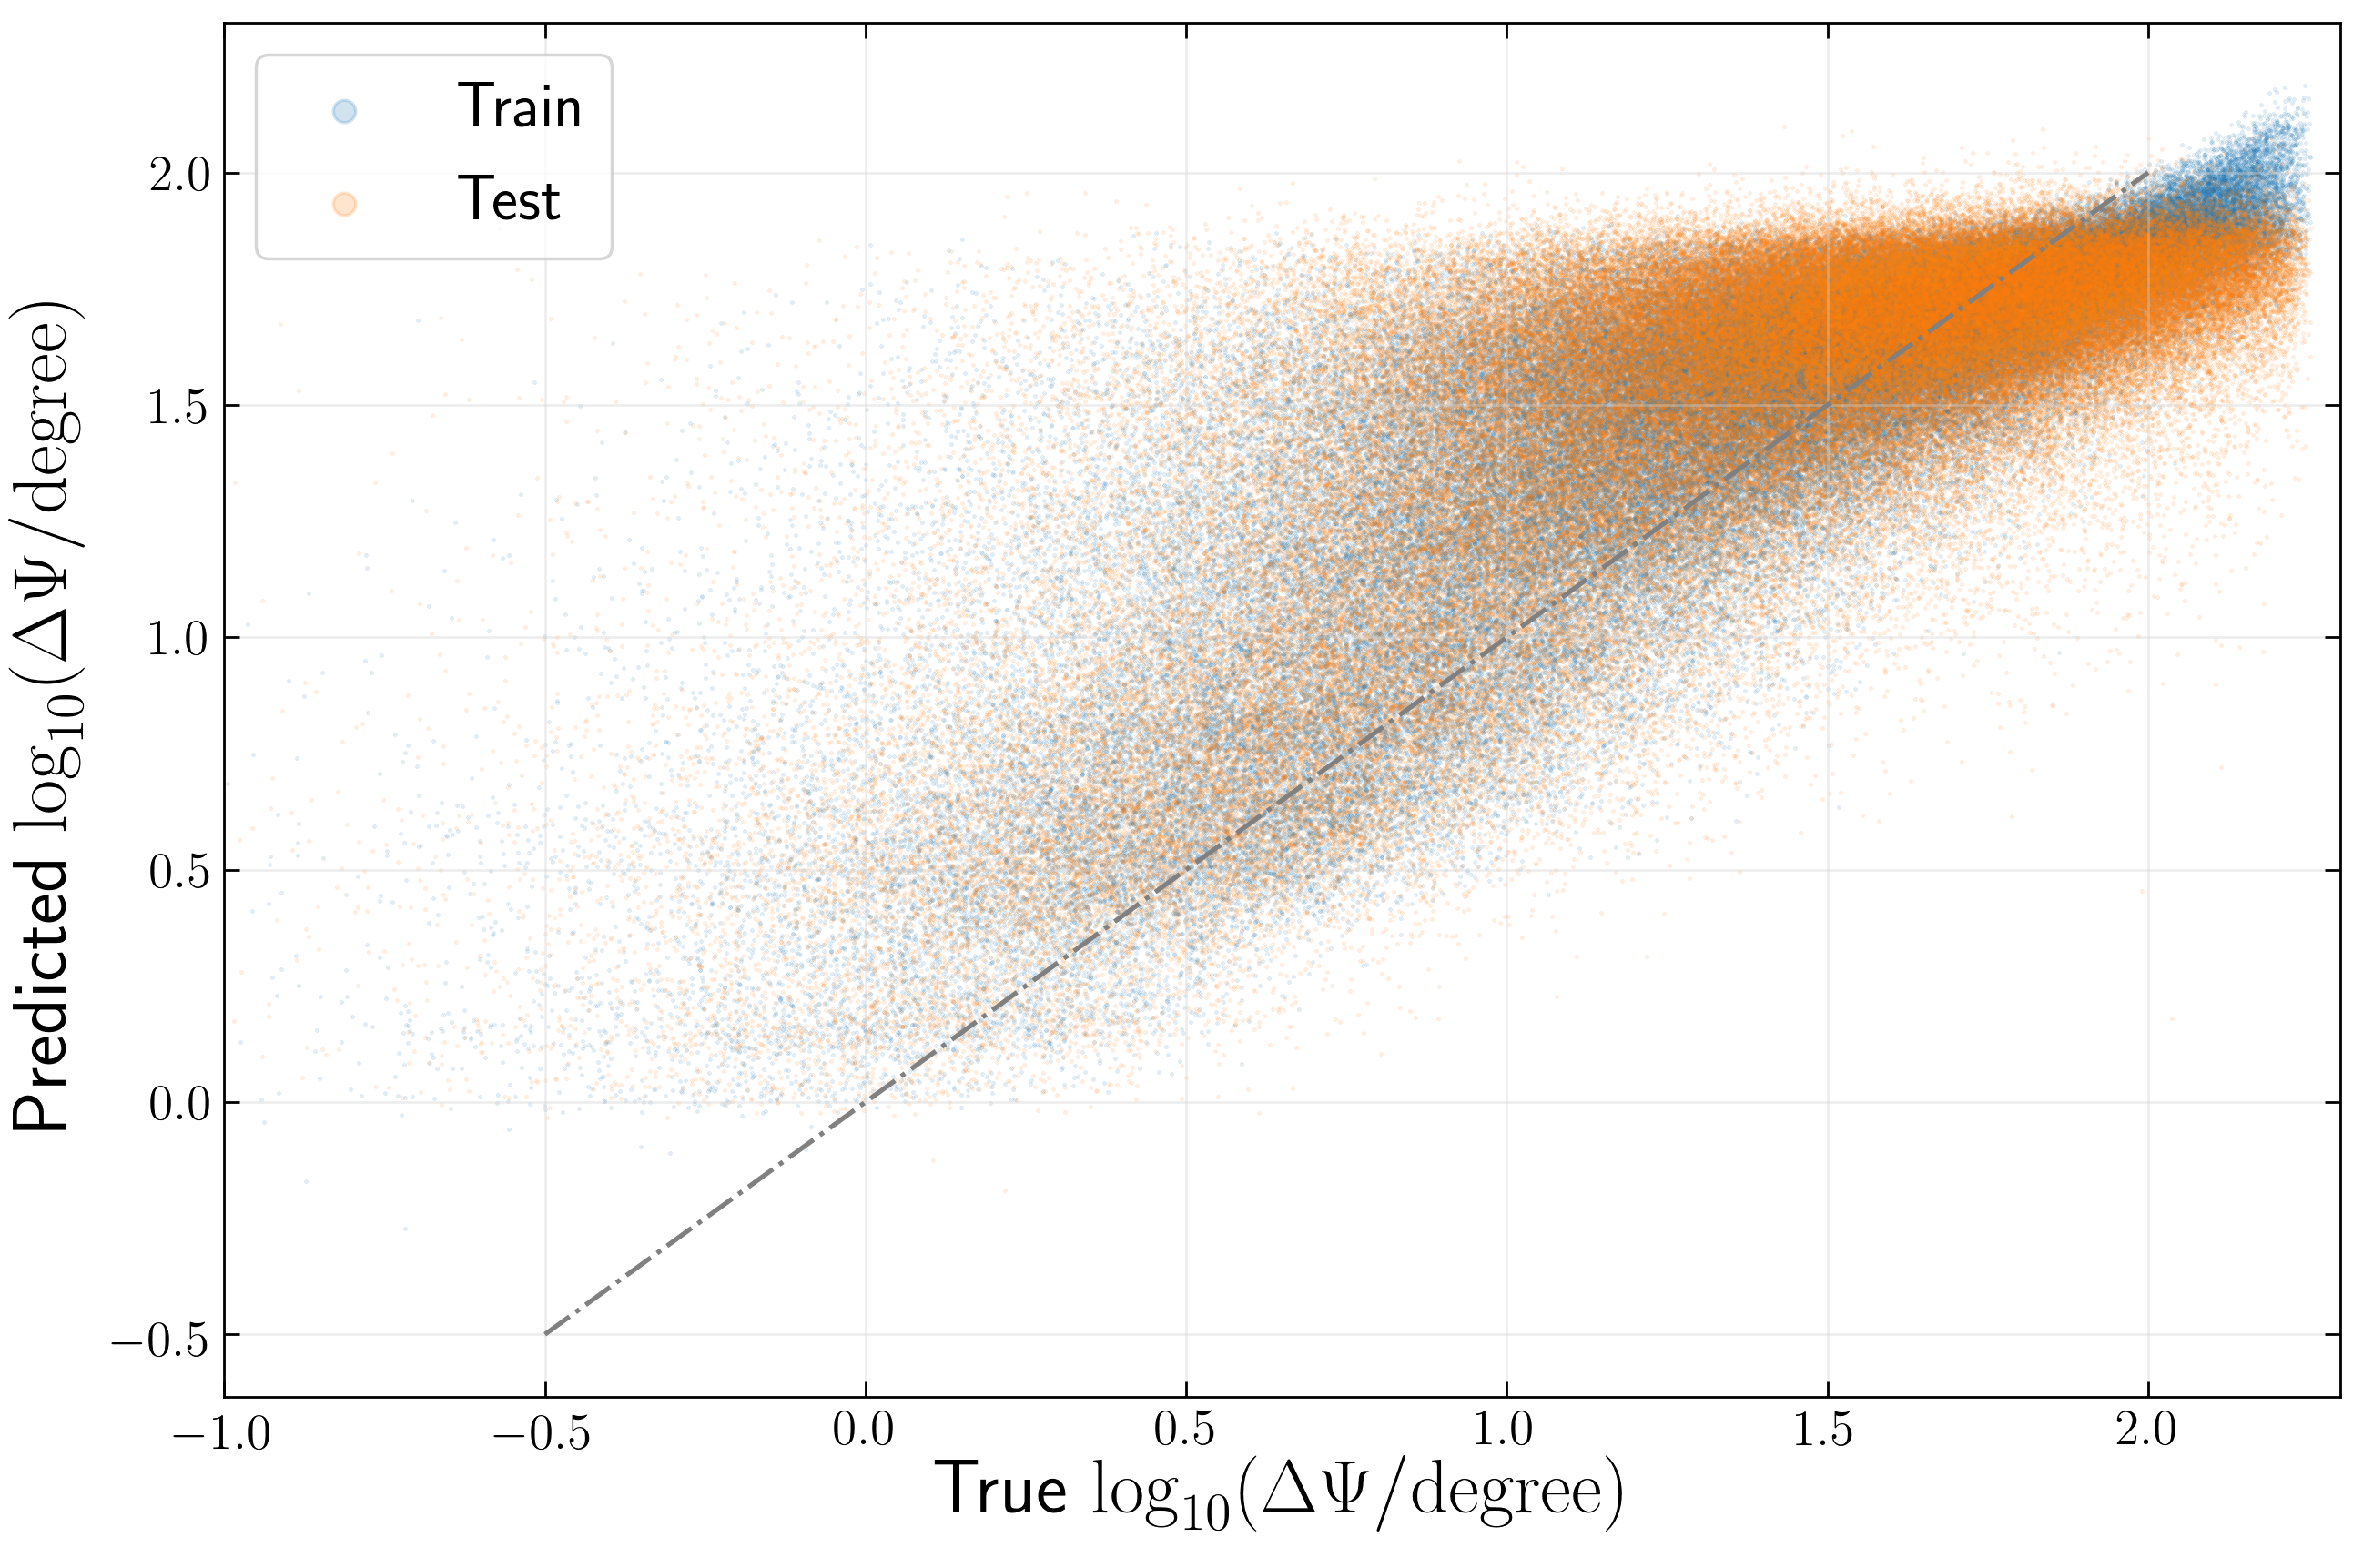

In [13]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, 
                                                         test_size=0.5, 
                                                         random_state=1) 
#Unstandardized
forest = RandomForestRegressor(n_estimators=50, 
                               max_depth = 16,
                               #max_features = 4,
                               #min_samples_split = 100,
                               criterion='mse', #'entropy', 'genie'
                               random_state=1, 
                               n_jobs=10)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

fig, ax = plt.subplots(figsize = (12,8), dpi=250)
plt.scatter(np.log10((y_train) * 180. / np.pi), np.log10((y_train_pred)*180. / np.pi), s = 0.1, 
            alpha = 0.2, label = 'Train')
plt.scatter(np.log10((y_test) * 180. / np.pi), np.log10((y_test_pred)*180. / np.pi), s = 0.1, 
            alpha = 0.2, label = 'Test')
#plt.scatter(y_train* 180. / np.pi, y_train_pred*180. / np.pi, s = 0.1, 
#            alpha = 0.2, label = 'Train')
#plt.scatter(y_test * 180. / np.pi, y_test_pred*180. / np.pi, s = 0.1, 
#            alpha = 0.2, label = 'Test')
#plt.scatter(np.log10((10.**y_train) * 180. / np.pi), np.log10((10.**y_train_pred)*180. / np.pi), s = 0.1, 
#            alpha = 0.2, label = 'Train')
#plt.scatter(np.log10((10.**y_test) * 180. / np.pi), np.log10((10.**y_test_pred)*180. / np.pi), s = 0.1, 
#            alpha = 0.2, label = 'Test')

plt.plot(np.linspace(-0.5, 2., 500), np.linspace(-0.5, 2., 500), ls = '-.', c = 'gray')
plt.xlim(-1, 2.3)
lgnd = plt.legend(loc=2, fontsize=20)
plt.xlabel(r'True $\log_{10}(\Delta \Psi / \textrm{degree})$', fontsize = 24)
plt.ylabel(r'Predicted $\log_{10}(\Delta \Psi / \textrm{degree})$', fontsize = 24)

lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.show()

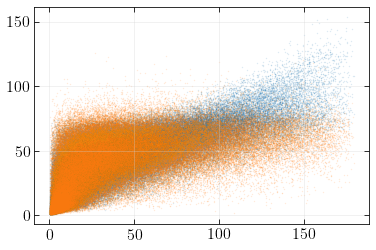

In [14]:
plt.scatter(y_train* 180. / np.pi, y_train_pred*180. / np.pi, s = 0.1, 
            alpha = 0.2, label = 'Train')
plt.scatter(y_test * 180. / np.pi, y_test_pred*180. / np.pi, s = 0.1, 
            alpha = 0.2, label = 'Test')

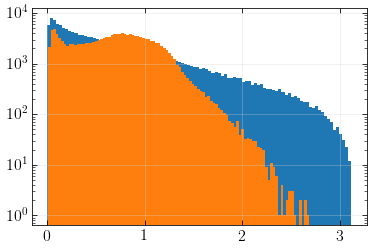

In [15]:
plt.hist(y_train, bins=100)
plt.hist(y_train_pred, bins=100)
#plt.hist(y_test, bins=100)
#plt.hist(y_test_pred, bins=100)
plt.yscale('log')

In [16]:
np.median(y_train_pred * 180. / np.pi)

40.14782453528231

In [17]:
np.mean(y_train)

0.6880293206360261

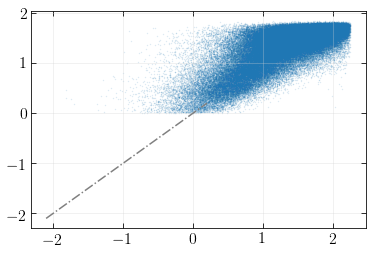

In [35]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, 
                                                         test_size=0.5, 
                                                         random_state=1) 
#Unstandardized
forest = RandomForestRegressor(n_estimators=100, 
                               max_depth = 15,
                               max_features = 4,
                               min_samples_split = 500,
                               criterion='mse', #'entropy', 'genie'
                               random_state=1, 
                               n_jobs=10)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


plt.scatter(y_test, y_test_pred, s = 0.1, alpha = 0.2)
plt.plot(np.linspace(-2.1, 0.2, 500), np.linspace(-2.1, 0.2, 500), ls = '-.', c = 'gray')

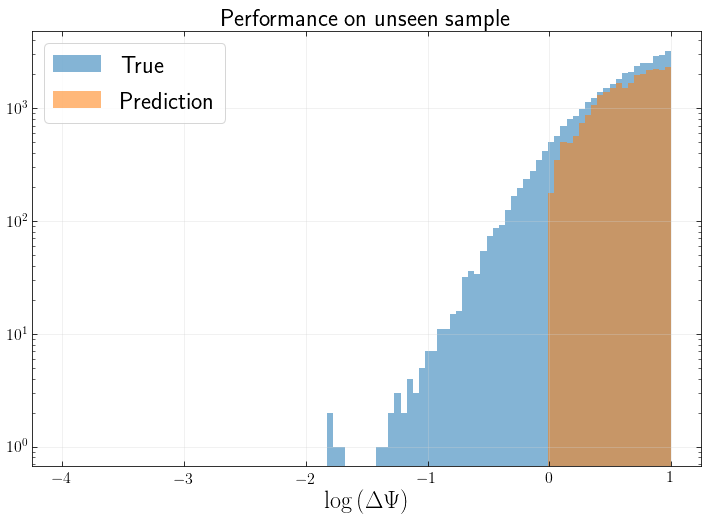

In [36]:
plt.figure(figsize = (12,8))
x_vals = np.linspace(-4,1,100)
plt.hist(y_test, bins = x_vals, alpha = 0.55, label = "True")
plt.hist(y_test_pred, bins = x_vals, alpha = 0.55, label = "Prediction")
plt.legend(loc = 2, fontsize = 24)
plt.yscale('log')
plt.xlabel(r'$\log\Big( \Delta\Psi\Big)$', fontsize = 24)
plt.title("Performance on unseen sample", fontsize = 24)
plt.show()

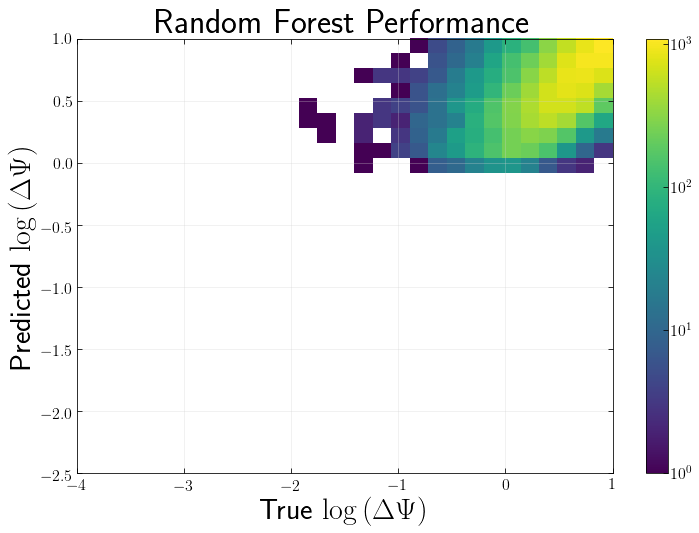

In [37]:
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(111)
#ax2 = f.add_subplot(122)
#fig, ax = plt.subplots()
cax = ax.hist2d(y_test, y_test_pred, 
       bins = [np.linspace(-4.,1.,30), np.linspace(-2.5,1.,30)], 
        cmap = 'viridis', norm=LogNorm())
ax.set_title('Random Forest Performance', fontsize = 34)
plt.xlabel(r'True $\log\Big( \Delta\Psi\Big)$', fontsize = 30)
plt.ylabel(r'Predicted $\log\Big( \Delta\Psi\Big)$', fontsize = 30)
plt.colorbar(cax[3], ax=ax, ticks=[1, 1e1, 1e2, 1e3, 1e4])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
#cbar = fig.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar

plt.show()

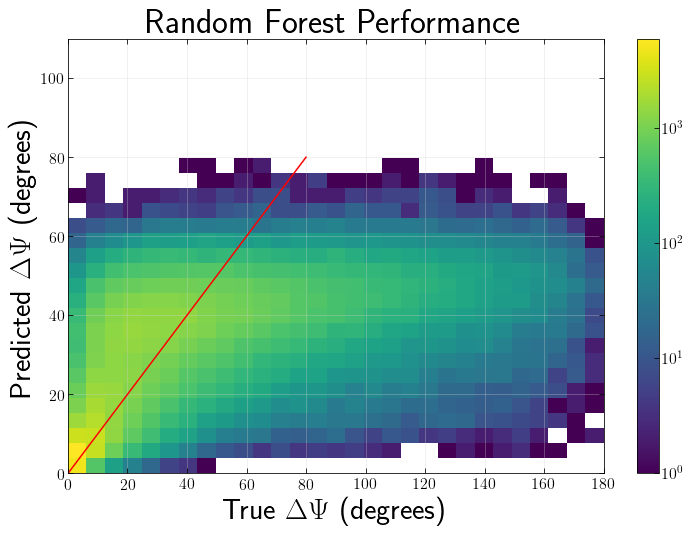

In [27]:
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(111)

cax = ax.hist2d(np.power(10,y_test)*180. / np.pi, np.power(10, y_test_pred)*180. / np.pi, 
       bins = [np.linspace(0,180.,30), np.linspace(0,110,30)], 
        cmap = 'viridis', norm=LogNorm())
ax.plot(np.linspace(0., 80., 100), np.linspace(0., 80., 100), color = 'r')
ax.set_title('Random Forest Performance', fontsize = 34)
plt.xlabel(r'True $\Delta\Psi$ (degrees)', fontsize = 30)
plt.ylabel(r'Predicted $\Delta\Psi$ (degrees)', fontsize = 30)
plt.colorbar(cax[3], ax=ax, ticks=[1, 1e1, 1e2, 1e3, 1e4])


plt.show()


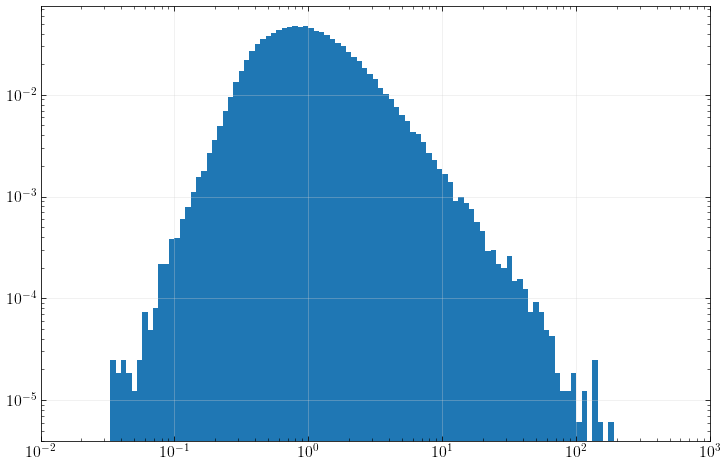

In [28]:
residual_quotient = np.power(10, y_test_pred) / np.power(10, y_test)
f = plt.figure(figsize=(12,8))

h = plt.hist(residual_quotient, weights=np.ones_like(residual_quotient) / len(residual_quotient), bins = np.logspace(-3.,3.,151))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-2, 1e3)
plt.show()

In [21]:
print np.sum(h[0])
mask = h[1] < 0.5
mask += h[1] > 2.
mask = ~mask

hist = np.append(h[0][0], h[0])
print np.sum(hist[mask]) / np.sum(h[0])

mask = h[1] < 0.2
mask += h[1] > 5.
mask = ~mask

hist = np.append(h[0][0], h[0])
print np.sum(hist[mask]) / np.sum(h[0])

1.0000000000004736
0.6477081629314497
0.9298020611810804


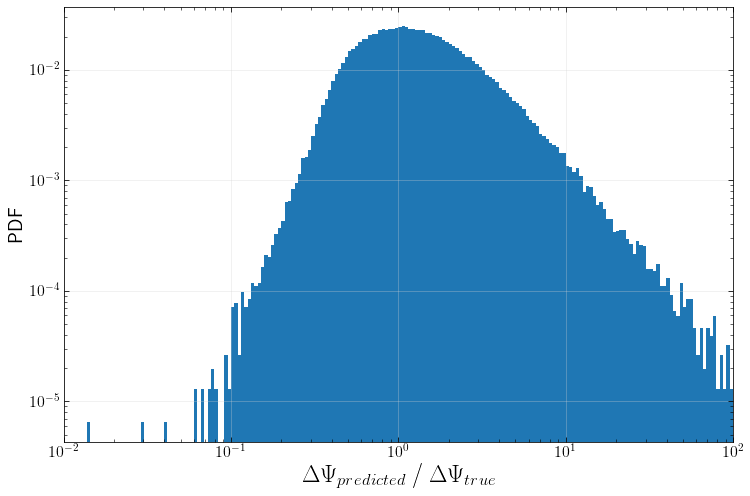

In [20]:
residual_log_quotient =  y_test_pred / y_test
f = plt.figure(figsize=(12,8))

h = plt.hist(residual_log_quotient, weights=np.ones_like(residual_log_quotient) / float(len(residual_log_quotient)), bins = np.logspace(-3.,3.,301))
plt.yscale('log')
plt.xscale('log')
plt.ylabel("PDF", fontsize = 20)
plt.xlabel("$ \Delta\Psi_{predicted} \; \Bigg/ \; \Delta\Psi_{true}$", fontsize = 24)
plt.xlim(1e-2, 1e2)
plt.tick_params(labelsize = 16)
plt.show()

In [16]:
CVresults = pickle.load(open('/data/user/apizzuto/Nova/RandomForests/GridSearchResults_logSeparation_True_standardize_True'))
CVresults

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'n_estimators': [20, 40, 60, 80, 100, 200, 400, 600, 800, 1000], 'max_features': [1, 3, 6, 8, 11], 'min_samples_split': [100, 1000, 10000, 10000], 'max_depth': [4, 8, 12, 16, 20], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [18]:
CVresults.best_estimator_

<bound method RandomForestRegressor.score of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           n_estimators=800, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)>

In [19]:
?RandomForestRegressor

In [27]:
feature_cols = list(neutrinos_df.keys())
feature_cols.remove('true dpsi')

X,y = neutrinos_df[feature_cols].values, neutrinos_df['true dpsi'].values

test_vals = []
test_vals_std = []
train_vals = []
test_frac = 0.5

if True: #test_frac % 0.11 == 0:
    print("\nSize: {}".format(len(neutrinos_df['true dpsi'])*(1.-test_frac)))

X_train, X_test, y_train, y_test =  train_test_split(X, y, 
                                                     test_size=test_frac, 
                                                     random_state=1) 
#Unstandardized
forest = RandomForestRegressor(n_estimators=200, 
                               max_depth = 30,
                               max_features = 4,
                               min_samples_split = 10,
                               criterion='mse',  #'mse', #'entropy', 'genie'
                               random_state=1, 
                               n_jobs=10)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

if True: #test_frac % 0.11 == 0:
    print('MSE train: %.3f, test: %.3f' % (
            mean_squared_error(y_train, y_train_pred),
            mean_squared_error(y_test, y_test_pred)))
    print('R^2 train: %.3f, test: %.3f' % (
            r2_score(y_train, y_train_pred),
            r2_score(y_test, y_test_pred)))
test_vals.append(mean_squared_error(y_test, y_test_pred))
train_vals.append(mean_squared_error(y_train, y_train_pred))

#Unstandardized
stdsc = StandardScaler()
X_train_std = stdsc.fit(X_train).transform(X_train)
X_test_std = stdsc.transform(X_test)

forest.fit(X_train_std, y_train)
y_train_pred = forest.predict(X_train_std)
y_test_pred = forest.predict(X_test_std)

if True: #test_frac % 0.11 == 0:
    print("Standardized version:")
    print('MSE train: %.3f, test: %.3f' % (
            mean_squared_error(y_train, y_train_pred),
            mean_squared_error(y_test, y_test_pred)))
    print('R^2 train: %.3f, test: %.3f' % (
            r2_score(y_train, y_train_pred),
            r2_score(y_test, y_test_pred)))
test_vals_std.append(mean_squared_error(y_test, y_test_pred))


Size: 162706.5
MSE train: 0.043, test: 0.125
R^2 train: 0.828, test: 0.499
Standardized version:
MSE train: 0.043, test: 0.125
R^2 train: 0.828, test: 0.499


In [ ]:
plt.hist(y_train_pred, bins=100, histtype='step')
plt.hist(y_train, bins=100, histtype='step')
plt.hist(y_test_pred, bins=100, histtype='step')
plt.hist(y_test, bins=100, histtype='step')
plt.show()

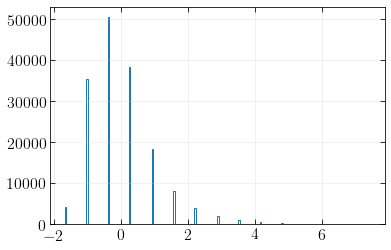

7.422620035226533


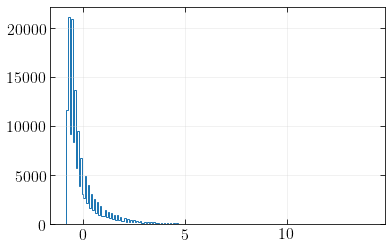

14.018313122344086


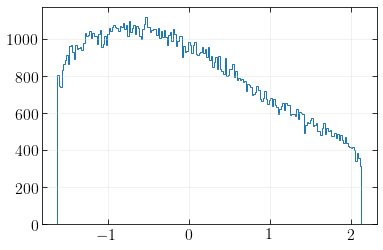

2.1304968945661185


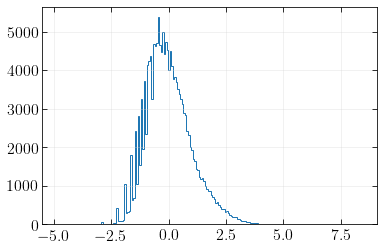

8.412891443280072


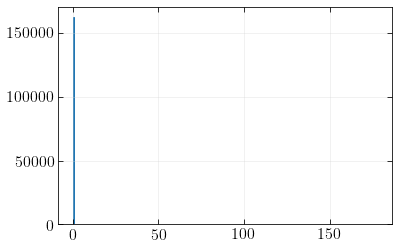

177.56243693468033


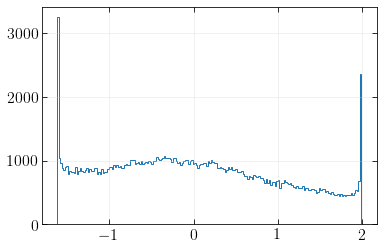

1.9929311855252252


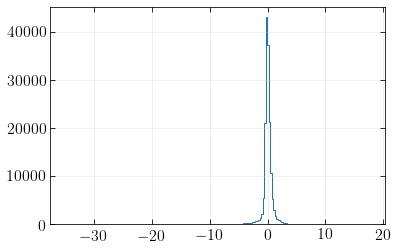

17.582096666885903


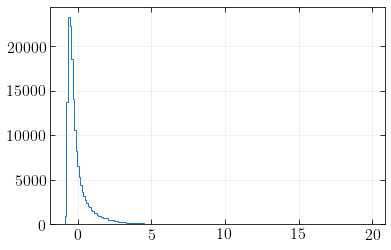

19.788831653415258


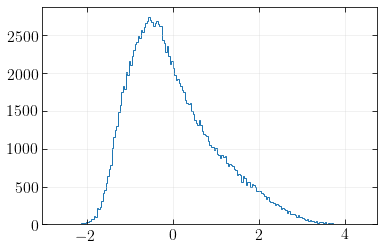

4.373321327983


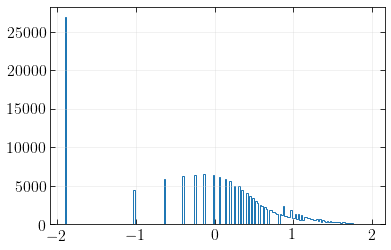

1.962187591855357


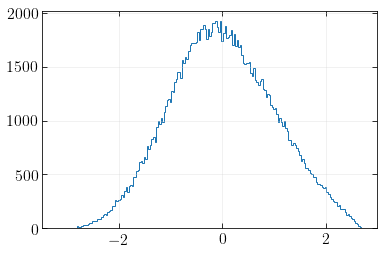

2.6954273319041917


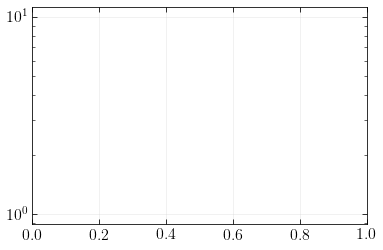

In [39]:
for x in X_train_std.T:
    plt.hist(x, histtype='step', bins=200)
    plt.show()
    print max(x)
plt.yscale('log')    

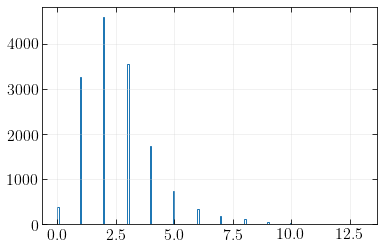

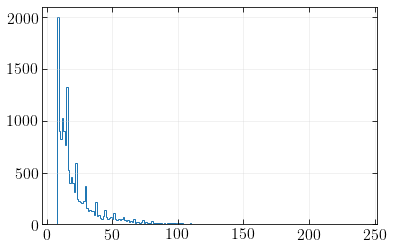

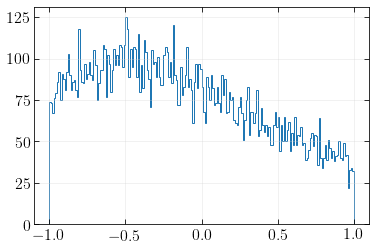

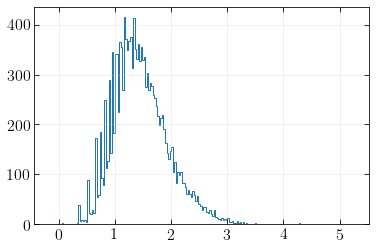

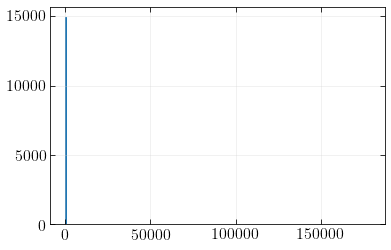

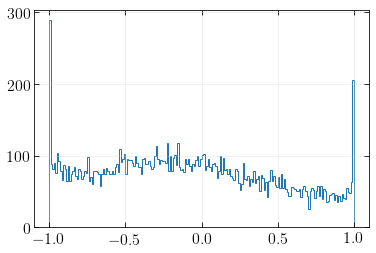

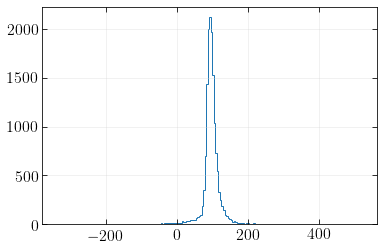

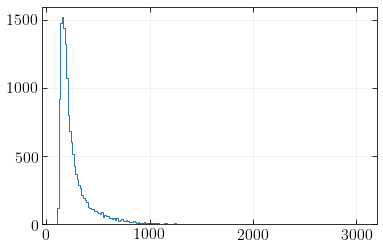

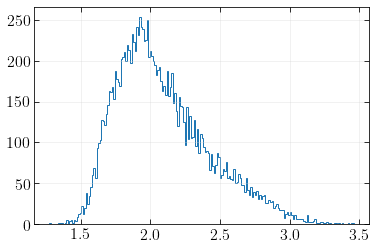

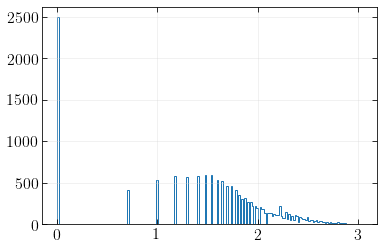

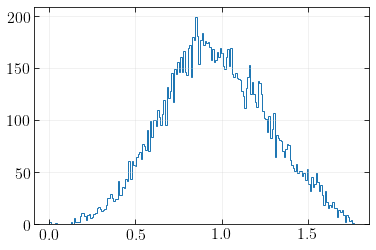

In [43]:
for x in X_train.T:
    plt.hist(x[:15000], histtype='step', bins=200)
    plt.show()

In [44]:
feature_cols

['nstring',
 'nchannel',
 'zen',
 'logE',
 'cascade energy',
 'monopod zen',
 'pidDeltaLLH',
 'pidPeglegLLH',
 'pidMonopodLLH',
 'pidLength',
 'monopod pegleg dpsi']

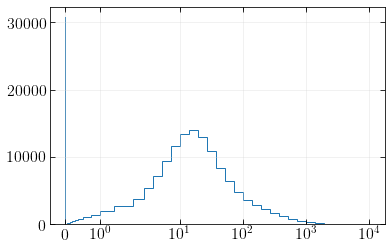

In [56]:
x = X_train.T[4]
plt.hist(x[:], histtype='step', bins = np.unique(np.append(np.linspace(-0.01, 0.001, 2), np.logspace(-3, 4, 50))))
#plt.xscale('log')
plt.xscale('symlog')
plt.show()

In [18]:
scaled_nus

nstring  nchannel       zen      logE  cascade energy  monopod zen  \
0             1        10 -0.036626  0.778692        6.007481     0.780759   
1             3        10 -0.035555  0.837508        5.768720    -0.614838   
2             1         9  0.185961  0.947197        5.525167     0.260547   
3             2         9 -0.326403  0.698947        4.999740    -0.032095   
4             2        10 -0.117743  0.799446        6.301535    -0.947080   
5             3         8 -0.284877  1.186113       15.350146    -0.144200   
6             1         9 -0.660095  0.647383        0.000000    -0.587669   
7             1         8 -0.354277  0.744293        0.000000     0.085925   
8             3        10  0.717447  0.944496        4.360279    -0.191419   
9             2         9 -0.839405  0.793805        0.670212    -0.609005   
10            3        10 -0.156111  0.735601        4.330029    -0.196142   
11            3         9 -0.542011  0.823474        0.000000     0.165337   
12            3        13 -0.747540  1.103749        6.038391    -0.226884   
13            2         8 -0.910738  0.763616        1.362505    -0.674316   
14            4         8 -0.553020  0.744293        0.000000    -0.546341   
15            2         8 -0.734656  0.967755        8.174426    -0.627030   
16            2         8 -0.930717  1.143188       13.905560    -0.935082   
17            2         8  0.269247  1.358982        5.095021    -0.030620   
18            3         8 -0.948486  0.522444        0.000000    -0.408563   
19            2         8  0.118280  0.522444        0.000000    -0.861973   
20            1         9  0.570473  0.610114        4.074869     0.997421   
21            1         8 -0.097817  0.647383        0.000000    -0.999997   
22            1         9 -0.605040  0.744293        0.000000    -0.482446   
23            2         8  0.366384  0.737895        5.468835    -0.689197   
24            2         9  0.760618  0.647383        0.000000     0.725623   
25            3         8 -0.407228  0.943824        8.786666     0.056105   
26            2        13 -0.026388  0.747486        1.150949    -0.933168   
27            2        13 -0.001234  0.863493        0.642864    -0.322474   
28            3        11 -0.438970  0.594935        3.934909    -0.433247   
29            1        11 -0.374801  0.896375        7.877254    -0.319905   
...         ...       ...       ...       ...             ...          ...   
325390        0       100 -0.395869  2.868870      739.383117    -0.996709   
325391        3        43  0.177133  1.929699       85.054893     0.626782   
325392        2        45  0.515516  2.854411      714.063572     0.605648   
325393        0        21  0.023307  1.911140       60.406671    -0.188479   
325394        0        25  0.023828  2.628533      356.321357    -0.478386   
325395        3       109 -0.674227  2.937750      866.462132    -0.354543   
325396        6       107  0.927124  2.524143      315.434939     0.832780   
325397        0        50  0.647529  2.214851       90.742725     0.866694   
325398        6       166  0.265699  2.758000      572.795700     0.172732   
325399        3        70 -0.834980  2.674284      311.422300    -0.322191   
325400        4        89  0.892582  3.426137     2667.702160    -0.571817   
325401        0        58 -0.333787  2.860309      612.841381    -0.569644   
325402        6        53  0.180722  2.911160      689.575142     0.010482   
325403        0        41 -0.459501  2.372370       96.955657    -0.714633   
325404        2        37 -0.118714  2.949716      834.057381    -0.798454   
325405        1        46 -0.230174  2.690415      489.137309     0.474682   
325406        7       134 -0.172551  2.728521      416.435734    -0.501962   
325407        5       108 -0.712761  2.452996      171.679429    -0.261956   
325408        1        47  0.843444  2.644967      434.876411    -0.219313   
325409        3        45 -0.7